In [127]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.colors as mcolors
from math import *
rc('font',**{'family':'serif','serif':['Palatino'],'size': 16})
rc('text', usetex=True)
rc('lines', **{'linewidth':3.0})
rc('axes', **{'labelsize':22})

In [7]:
def K(x1,x2,y1,y2,a,h):
    _x1,_x2=np.meshgrid(x1,x2)
    _y1,_y2=np.meshgrid(y1,y2)
    return a**2*np.exp(-((_x1-_x2)**2+(_y1-_y2)**2)/(2*h**2))

In [180]:
def GPR_Kernel (a,h,sigma,width=9,badpix=[0,0],close_badpix=None):
    x=np.outer(np.ones(width),np.linspace(badpix[0]-(width-1)/2,badpix[0]+(width-1)/2,width))
    y=np.outer(np.linspace(badpix[1]-(width-1)/2,badpix[1]+(width-1)/2,width),np.ones(width))
    # Reshape into an 1D vector of coordinates
    x=np.reshape(x,width**2)
    y=np.reshape(y,width**2)
    # Translate the location of bad pixel to the index to remove
    index_remove=int(np.intersect1d(np.where(x==badpix[0]),np.where(y==badpix[1])))
    x=np.delete(x,index_remove)
    y=np.delete(y,index_remove)
    if close_badpix is not None:
        new_index_remove=int(np.intersect1d(np.where(x==close_badpix[0]),np.where(y==close_badpix[1])))
        x=np.delete(x,new_index_remove)
        y=np.delete(y,new_index_remove)
    Cov_data=np.identity(x.size)*sigma**2    
    Kinv=np.linalg.inv(K(x,x,y,y,a,h)+Cov_data)
    Kernel=np.dot(K(x,badpix[0],y,badpix[1],a,h),Kinv)
    if close_badpix is not None:
        Kernel=np.insert(Kernel,new_index_remove,0)
    Kernel=np.insert(Kernel,index_remove,0)
    Kernel=np.reshape(Kernel,(width,width))
    # Normalization
    Kernel/=np.sum(np.sum(Kernel,axis=1))
    return Kernel

In [128]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=-1):
    if n == -1:
        n = cmap.N
    new_cmap = mcolors.LinearSegmentedColormap.from_list(
         'trunc({name},{a:.2f},{b:.2f})'.format(name=cmap.name, a=minval, b=maxval),
         cmap(np.linspace(minval, maxval, n)))
    return new_cmap

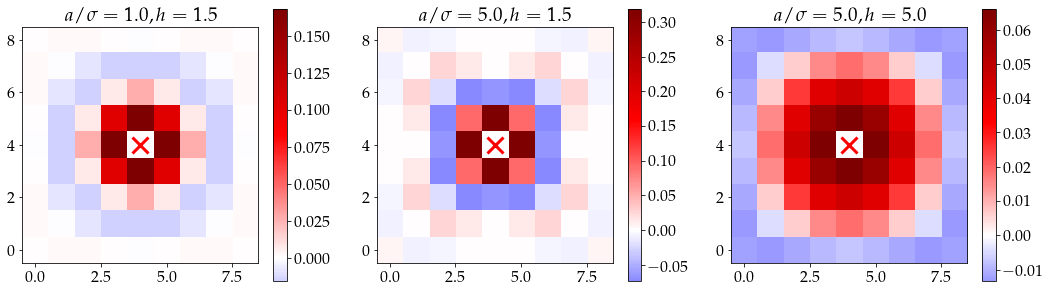

In [186]:
a=np.array([4,20,20])
h=np.array([1.5,1.5,5])
sigma=np.array([4,4,4])
fig,ax=plt.subplots(1,3,figsize=(18,5))
for i in range (a.size):
    kernel=GPR_Kernel(a[i],h[i],sigma[i])
    minval=np.amin(np.amin(kernel,axis=1))
    maxval=np.amax(np.amax(kernel,axis=1))
    seismic_t = truncate_colormap(plt.get_cmap("seismic"), 0.5*(1 + minval/maxval), 1)
    im=ax[i].imshow(kernel,origin="lower",cmap=seismic_t)
    fig.colorbar(im,ax=ax[i])
    ax[i].plot(4,4,"rx",markersize=16,mew=3)
    ax[i].set_title("$a/\sigma={},h={}$".format(a[i]/sigma[i],h[i]))
#plt.savefig("Kernels at Different Parameter Values")
plt.show()

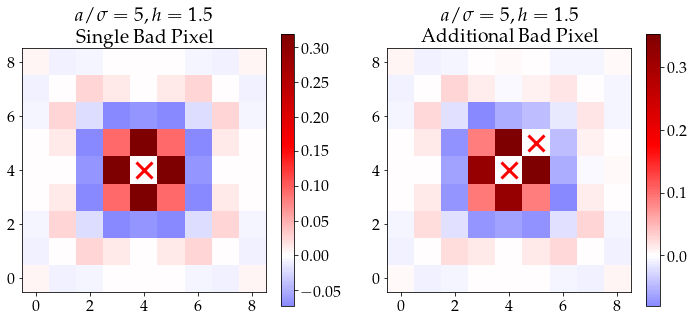

In [204]:
fig,ax=plt.subplots(1,2,figsize=(12,5))
kernel_one=GPR_Kernel(20,1.5,4)
minval=np.amin(np.amin(kernel_one,axis=1))
maxval=np.amax(np.amax(kernel_one,axis=1))
seismic_t = truncate_colormap(plt.get_cmap("seismic"), 0.5*(1 + minval/maxval), 1)
im=ax[0].imshow(kernel_one,origin="lower",cmap=seismic_t)
fig.colorbar(im,ax=ax[0])
ax[0].plot(4,4,"rx",markersize=16,mew=3)
ax[0].set_title("$a/\sigma=5,h=1.5$ \n Single Bad Pixel")
kernel_two=GPR_Kernel(20,1.5,4,close_badpix=[1,1]) # Change the coordinate (x,y) of the bad pixel here
minval=np.amin(np.amin(kernel_two,axis=1))
maxval=np.amax(np.amax(kernel_two,axis=1))
seismic_t = truncate_colormap(plt.get_cmap("seismic"), 0.5*(1 + minval/maxval), 1)
im=ax[1].imshow(kernel_two,origin="lower",cmap=seismic_t)
fig.colorbar(im,ax=ax[1])
ax[1].plot(4,4,"rx",markersize=16,mew=3)
ax[1].plot(4+1,4+1,"rx",markersize=16,mew=3)
ax[1].set_title("$a/\sigma=5,h=1.5$ \n Additional Bad Pixel")
plt.savefig("Neighbouring Bad Pixels")
plt.show()